# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части. 

In [5]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [6]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 15 # 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 15764


In [7]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ] 
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])
    
    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [8]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [9]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])
    
    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна. 

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие. 

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно. 

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее. 
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству. 

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты. 
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет. 
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная? 
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

### Оценка базовой модели уже на задаче классификации 4 классов

In [13]:
class RnnModel(nn.Module):
    def __init__(self, vocab_size, hidden_dim=256, num_classes=4, agg_type='max'):
        super().__init__()
        self.emb = torch.nn.Embedding(vocab_size, hidden_dim)
        self.rnn = torch.nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = torch.nn.Linear(hidden_dim, hidden_dim)
        self.projection = torch.nn.Linear(hidden_dim, num_classes)
        
        self.non_lin = torch.nn.Tanh()
        self.dropout = torch.nn.Dropout(p=0.1)
        
        self.agg_type = agg_type
        
    def forward(self, input_batch):
        embs = self.emb(input_batch)
        output_emb, output_h = self.rnn(embs)
        
        if self.agg_type == 'max':
            output_agg = output_emb.max(dim=1)[0]
        elif self.agg_type == 'mean':
            output_agg = output_emb.mean(dim=1)
        else:
            raise ValueError('Error in agg type')
            
        output_lin = self.linear(self.dropout(self.non_lin(output_agg)))
        projection = self.projection(self.non_lin(output_lin))
        
        return projection

In [14]:
def train_base(loader, num_epochs=5):
    
    models_type = dict()
    losses_train_type = dict()
    accs_train_type = dict()
    accs_val_type = dict()
    
    for agg_type in ['max', 'mean']:
        print(f'aggregation type: {agg_type}')
        
        base_rnn = RnnModel(len(vocab)).to(device)
        criterion = torch.nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
        optimizer = torch.optim.Adam(base_rnn.parameters())

        losses = list()
        accs = list()
        accs_val = list()
        base_rnn.train()
        for epoch in range(num_epochs):
            epoch_losses = list()
            epoch_accs = list()
            for batch in tqdm(loader, desc=f'Training epoch: {epoch + 1}'):
                optimizer.zero_grad()
                logits = base_rnn(batch['input_ids'])
                loss = criterion(logits, batch['label'])
                preds = logits.argmax(dim=1)
                loss.backward()
                optimizer.step()
                epoch_losses.append(loss.item())
                epoch_accs.append((sum(preds==batch['label']) / len(batch['label'])).item())
                
            losses.append(sum(epoch_losses) / len(epoch_losses))
            accs.append(sum(epoch_accs) / len(epoch_accs))
            
            base_rnn.eval()
            accs_val.append(evaluate(base_rnn, eval_dataloader))
            base_rnn.train()
                
        models_type[agg_type] = base_rnn
        losses_train_type[agg_type] = losses
        accs_train_type[agg_type] = accs
        accs_val_type[agg_type] = accs_val
        
    return models_type, losses_train_type, accs_train_type, accs_val_type

In [15]:
models_base_t, losses_base_t, accs_base_t, accs_val_base_t = train_base(train_dataloader, 5)

aggregation type: max


Training epoch: 1:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch: 2:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch: 3:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch: 4:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch: 5:   0%|          | 0/3750 [00:00<?, ?it/s]

aggregation type: mean


Training epoch: 1:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch: 2:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch: 3:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch: 4:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch: 5:   0%|          | 0/3750 [00:00<?, ?it/s]

In [10]:
def plot_results(name, losses_t, accs_t, accs_val_t, num_epochs):
    agg_types = ['max', 'mean']
    epochs = [i + 1 for i in range(num_epochs)]
    
    fig, axes = plt.subplots(1, 3, figsize=(17,7))
    for idx, agg_type in enumerate(agg_types):
        if idx:
            axes[0].plot(epochs, losses_t[agg_type], label=agg_type, color='red')
            axes[1].plot(epochs, accs_t[agg_type], label=agg_type, color='red')
            axes[2].plot(epochs, accs_val_t[agg_type], label=agg_type, color='red')
        else:
            axes[0].plot(epochs, losses_t[agg_type], label=agg_type, color='blue')
            axes[1].plot(epochs, accs_t[agg_type], label=agg_type, color='blue')
            axes[2].plot(epochs, accs_val_t[agg_type], label=agg_type, color='blue')
    
    for i in range(3):
        axes[i].grid(True)
        axes[i].legend()
    
    axes[0].set_title(f'Losses training process with model {name}')
    axes[1].set_title(f'Accs training process with model {name}')
    axes[2].set_title(f'Accs validation process with model {name}')
        
    plt.show()

## Улучшенные модели

### 1) Использование GRU/LSTM и подбор гиперпараметров в опытах

In [11]:
class LstmModel(nn.Module):
    def __init__(self, vocab_size, hidden_dim=256, p_drop=0.05, num_classes=4, agg_type='max'):
        super().__init__()
        self.emb = torch.nn.Embedding(vocab_size, hidden_dim)
        self.lstm = torch.nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        # Используем LSTM
        self.linear = torch.nn.Linear(hidden_dim, hidden_dim)
        self.projection = torch.nn.Linear(hidden_dim, num_classes)
        
        self.non_lin = torch.nn.Tanh()
        self.dropout = torch.nn.Dropout(p=p_drop)
        # Подбираем гиперпараметр
        
        self.agg_type = agg_type
        
    def forward(self, input_batch):
        embs = self.emb(input_batch)
        output_emb, output_h_c = self.lstm(embs)
        
        if self.agg_type == 'max':
            output_agg = output_emb.max(dim=1)[0]
        elif self.agg_type == 'mean':
            output_agg = output_emb.mean(dim=1)
        else:
            raise ValueError('Error in agg type')
            
        output_lin = self.linear(self.dropout(self.non_lin(output_agg)))
        projection = self.projection(self.non_lin(output_lin))
        
        return projection

In [14]:
def train_lstm(loader, num_epochs=5):
    
    clip_value = 1.0
    models_type = dict()
    losses_train_type = dict()
    accs_train_type = dict()
    accs_val_type = dict()
    
    for agg_type in ['max', 'mean']:
        print(f'aggregation type: {agg_type}')
        
        lstm = LstmModel(vocab_size=len(vocab), hidden_dim=300, p_drop=0.15).to(device)
        criterion = torch.nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
        optimizer = torch.optim.Adam(lstm.parameters())

        losses = list()
        accs = list()
        accs_val = list()
        lstm.train()
        for epoch in range(num_epochs):
            epoch_losses = list()
            epoch_accs = list()
            tqdm.write(f'Training epoch: {epoch + 1}')
            #with tqdm(loader, unit="batch") as tepoch:
            for batch in loader:
                optimizer.zero_grad()
                logits = lstm(batch['input_ids'])
                loss = criterion(logits, batch['label'])
                preds = logits.argmax(dim=1)
                loss.backward()

                torch.nn.utils.clip_grad_value_(lstm.parameters(), clip_value)
                optimizer.step()

                epoch_losses.append(loss.item())
                epoch_accs.append((sum(preds==batch['label']) / len(batch['label'])).item())

                #tepoch.set_description(f"Epoch {epoch + 1}")
                #tepoch.set_postfix(loss=loss.item())
                #tepoch.update(1)
            
            final_train_loss = sum(epoch_losses) / len(epoch_losses)
            final_train_acc = sum(epoch_accs) / len(epoch_accs)
            tqdm.write(f'loss epoch: {final_train_loss}, acc epoch: {final_train_acc}')
            losses.append(final_train_loss)
            accs.append(final_train_acc)
            
            lstm.eval()
            accs_val.append(evaluate(lstm, eval_dataloader))
            lstm.train()
                
        models_type[agg_type] = lstm
        losses_train_type[agg_type] = losses
        accs_train_type[agg_type] = accs
        accs_val_type[agg_type] = accs_val
        
    return models_type, losses_train_type, accs_train_type, accs_val_type

In [15]:
models_lstm_t, losses_lstm_t, accs_lstm_t, accs_val_lstm_t = train_lstm(train_dataloader, 5)

aggregation type: max
Training epoch: 1
loss epoch: 0.34844360877275465, acc epoch: 0.8765
Training epoch: 2
loss epoch: 0.21146982168480755, acc epoch: 0.9274666666666667
Training epoch: 3
loss epoch: 0.1584458418369293, acc epoch: 0.9454416666666666
Training epoch: 4
loss epoch: 0.12039732469745601, acc epoch: 0.9568333333333333
Training epoch: 5
loss epoch: 0.09106590488290725, acc epoch: 0.9675416666666666
aggregation type: mean
Training epoch: 1
loss epoch: 0.3519023846377929, acc epoch: 0.8762333333333333
Training epoch: 2
loss epoch: 0.2172792407947282, acc epoch: 0.9257
Training epoch: 3
loss epoch: 0.16540248813703656, acc epoch: 0.9427666666666666
Training epoch: 4
loss epoch: 0.12521632201125224, acc epoch: 0.9557166666666667
Training epoch: 5
loss epoch: 0.09730799518156176, acc epoch: 0.965325


### 2) Использование усложенной RNN и конкатенация эмбединнгов

In [20]:
class BetterRnnModel(nn.Module):
    def __init__(
        self, vocab_size, hidden_dim=256, 
        num_classes=4, num_layers=2,
        is_bidirect=True, agg_type='max'
    ):
        super().__init__()
        self.emb = torch.nn.Embedding(vocab_size, hidden_dim)
        self.rnn = torch.nn.RNN(
            hidden_dim, hidden_dim, 
            batch_first=True, 
            num_layers=num_layers,
            bidirectional=is_bidirect
        ) # Здесь используется усложенная RNN
        self.linears = torch.nn.Sequential(
            torch.nn.Linear(4 * hidden_dim, 2 * hidden_dim),
            torch.nn.Tanh(),
            torch.nn.Dropout(p=0.07),
            torch.nn.Linear(2 * hidden_dim, hidden_dim),
            torch.nn.Tanh(),
        ) # Добавили 1 линейный слой
        self.projection = torch.nn.Linear(hidden_dim, num_classes)
        
        self.agg_type = agg_type
        self.num_layers = num_layers
        
    def forward(self, input_batch):
        embs = self.emb(input_batch)
        output_emb, output_h = self.rnn(embs)
        output_h = torch.transpose(output_h, 0, 1)
        
        if self.agg_type == 'max':
            output_agg = output_emb.max(dim=1)[0]
        elif self.agg_type == 'mean':
            output_agg = output_emb.mean(dim=1)
        else:
            raise ValueError('Error in agg type')
        
        one_direct_h = output_h[:, :self.num_layers, :].mean(dim=1)
        two_direct_h = output_h[:, self.num_layers:, :].mean(dim=1)
        both_direct_h = torch.cat([one_direct_h, two_direct_h], dim=1)
        
        result_emb = torch.cat([output_agg, both_direct_h], dim=1)
            
        output_lin = self.linears(result_emb)
        projection = self.projection(output_lin)
        
        return projection

In [21]:
def train_rnn_better(loader, num_epochs=5):
    
    clip_value = 1.0
    models_type = dict()
    losses_train_type = dict()
    accs_train_type = dict()
    accs_val_type = dict()
    
    for agg_type in ['max', 'mean']:
        print(f'aggregation type: {agg_type}')
        
        rnn_better = BetterRnnModel(vocab_size=len(vocab), hidden_dim=300).to(device)
        criterion = torch.nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
        optimizer = torch.optim.Adam(rnn_better.parameters())

        losses = list()
        accs = list()
        accs_val = list()
        rnn_better.train()
        for epoch in range(num_epochs):
            epoch_losses = list()
            epoch_accs = list()
            tqdm.write(f'Training epoch: {epoch + 1}')
            #with tqdm(loader, unit="batch") as tepoch:
            for batch in loader:
                optimizer.zero_grad()
                logits = rnn_better(batch['input_ids'])
                loss = criterion(logits, batch['label'])
                preds = logits.argmax(dim=1)
                loss.backward()

                torch.nn.utils.clip_grad_value_(rnn_better.parameters(), clip_value)
                optimizer.step()

                epoch_losses.append(loss.item())
                epoch_accs.append((sum(preds==batch['label']) / len(batch['label'])).item())

                #tepoch.set_description(f"Epoch {epoch + 1}")
                #tepoch.set_postfix(loss=loss.item())
                #tepoch.update(1)
                
            final_train_loss = sum(epoch_losses) / len(epoch_losses)
            final_train_acc = sum(epoch_accs) / len(epoch_accs)
            tqdm.write(f'loss epoch: {final_train_loss}, acc epoch: {final_train_acc}')
            losses.append(final_train_loss)
            accs.append(final_train_acc)
            
            rnn_better.eval()
            accs_val.append(evaluate(rnn_better, eval_dataloader))
            rnn_better.train()
                
        models_type[agg_type] = rnn_better
        losses_train_type[agg_type] = losses
        accs_train_type[agg_type] = accs
        accs_val_type[agg_type] = accs_val
        
    return models_type, losses_train_type, accs_train_type, accs_val_type

In [22]:
models_rnn_t, losses_rnn_t, accs_rnn_t, accs_val_rnn_t = train_rnn_better(train_dataloader, 7)

aggregation type: max
Training epoch: 1
loss epoch: 0.8395837321599324, acc epoch: 0.6433
Training epoch: 2
loss epoch: 0.4701688995321592, acc epoch: 0.83875
Training epoch: 3
loss epoch: 0.3862280237485965, acc epoch: 0.8728916666666666
Training epoch: 4
loss epoch: 0.34566707146763803, acc epoch: 0.8869166666666667
Training epoch: 5
loss epoch: 0.3157247086758415, acc epoch: 0.8990083333333333
Training epoch: 6
loss epoch: 0.3062387877171238, acc epoch: 0.9030416666666666
Training epoch: 7
loss epoch: 0.28350683532208204, acc epoch: 0.9102166666666667
aggregation type: mean
Training epoch: 1
loss epoch: 0.5356157348195711, acc epoch: 0.7823333333333333
Training epoch: 2
loss epoch: 0.2989298928802212, acc epoch: 0.9007083333333333
Training epoch: 3
loss epoch: 0.25442014730026324, acc epoch: 0.9170916666666666
Training epoch: 4
loss epoch: 0.23244132489189506, acc epoch: 0.9241333333333334
Training epoch: 5
loss epoch: 0.24211028993924458, acc epoch: 0.9208416666666667
Training epoc

## Лучшая модель

In [24]:
class LstmModelBest(nn.Module):
    def __init__(self, vocab_size, hidden_dim=256, p_drop=0.05, num_layers=2, num_classes=4, agg_type='max'):
        super().__init__()
        self.emb = torch.nn.Embedding(vocab_size, hidden_dim)
        self.lstm = torch.nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=num_layers)
        # Используем LSTM
        self.linear = torch.nn.Linear(2 * hidden_dim, hidden_dim)
        self.projection = torch.nn.Linear(hidden_dim, num_classes)
        
        self.non_lin = torch.nn.Tanh()
        self.dropout = torch.nn.Dropout(p=p_drop)
        # Подбираем гиперпараметр
        
        self.agg_type = agg_type
        
    def forward(self, input_batch):
        embs = self.emb(input_batch)
        output_emb, output_h_c = self.lstm(embs)
        output_h = torch.transpose(output_h_c[0], 0, 1)
        
        if self.agg_type == 'max':
            output_agg = output_emb.max(dim=1)[0]
        elif self.agg_type == 'mean':
            output_agg = output_emb.mean(dim=1)
        else:
            raise ValueError('Error in agg type')
        
        h_sum = output_h.mean(dim=1)
        result_emb = torch.cat([h_sum, output_agg], dim=1)
            
        output_lin = self.linear(self.dropout(self.non_lin(result_emb)))
        projection = self.projection(self.non_lin(output_lin))
        
        return projection

In [25]:
def train_best(loader, num_epochs=5):
    
    clip_value = 1.0
    models_type = dict()
    losses_train_type = dict()
    accs_train_type = dict()
    accs_val_type = dict()
    
    for agg_type in ['max', 'mean']:
        print(f'aggregation type: {agg_type}')
        
        lstm = LstmModelBest(vocab_size=len(vocab), hidden_dim=300, p_drop=0.1).to(device)
        criterion = torch.nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
        optimizer = torch.optim.Adam(lstm.parameters())

        losses = list()
        accs = list()
        accs_val = list()
        lstm.train()
        for epoch in range(num_epochs):
            epoch_losses = list()
            epoch_accs = list()
            tqdm.write(f'Training epoch: {epoch + 1}')
            #with tqdm(loader, unit="batch") as tepoch:
            for batch in loader:
                optimizer.zero_grad()
                logits = lstm(batch['input_ids'])
                loss = criterion(logits, batch['label'])
                preds = logits.argmax(dim=1)
                loss.backward()

                torch.nn.utils.clip_grad_value_(lstm.parameters(), clip_value)
                optimizer.step()

                epoch_losses.append(loss.item())
                epoch_accs.append((sum(preds==batch['label']) / len(batch['label'])).item())

                #tepoch.set_description(f"Epoch {epoch + 1}")
                #tepoch.set_postfix(loss=loss.item())
                #tepoch.update(1)
                
            final_train_loss = sum(epoch_losses) / len(epoch_losses)
            final_train_acc = sum(epoch_accs) / len(epoch_accs)
            tqdm.write(f'loss epoch: {final_train_loss}, acc epoch: {final_train_acc}')
            losses.append(final_train_loss)
            accs.append(final_train_acc)
            
            lstm.eval()
            accs_val.append(evaluate(lstm, eval_dataloader))
            lstm.train()
                
        models_type[agg_type] = lstm
        losses_train_type[agg_type] = losses
        accs_train_type[agg_type] = accs
        accs_val_type[agg_type] = accs_val
        
    return models_type, losses_train_type, accs_train_type, accs_val_type

In [29]:
models_best_t, losses_best_t, accs_best_t, accs_best_rnn_t = train_best(train_dataloader, 3)

aggregation type: max
Training epoch: 1
loss epoch: 0.358863116256396, acc epoch: 0.8734583333333333
Training epoch: 2
loss epoch: 0.20670018529792628, acc epoch: 0.9296583333333334
Training epoch: 3
loss epoch: 0.1431667563697944, acc epoch: 0.9509333333333333
aggregation type: mean
Training epoch: 1
loss epoch: 0.35899079204698403, acc epoch: 0.8724333333333333
Training epoch: 2
loss epoch: 0.20686851664533218, acc epoch: 0.9303833333333333
Training epoch: 3
loss epoch: 0.14199480530358852, acc epoch: 0.9519666666666666


In [34]:
models_best_t['max'].eval()
models_best_t['mean'].eval()
print(
    f'best result on validation dataloader with max:',
    round(evaluate(models_best_t['max'], eval_dataloader), 3)
)
print(
    f'best result on validation dataloader with mean:',
    round(evaluate(models_best_t['mean'], eval_dataloader), 3)
)

best result on validation dataloader with max: 0.92
best result on validation dataloader with mean: 0.912


## Отчет

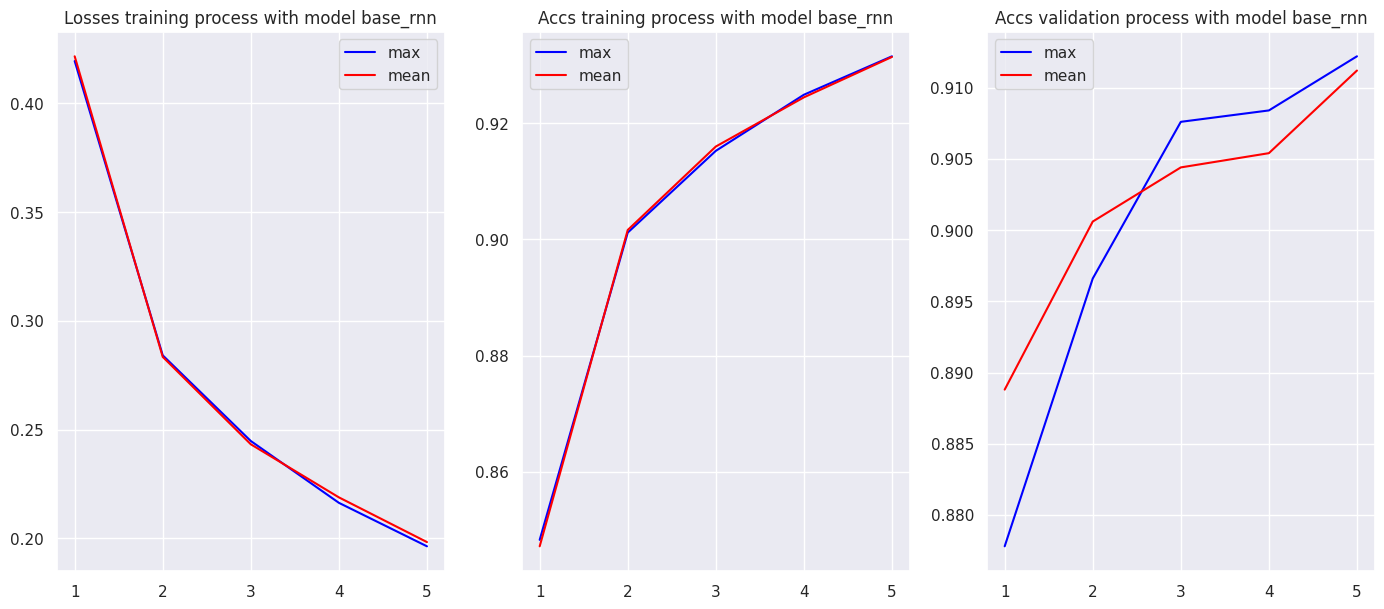

In [17]:
plot_results('base_rnn', losses_base_t, accs_base_t, accs_val_base_t, 5)

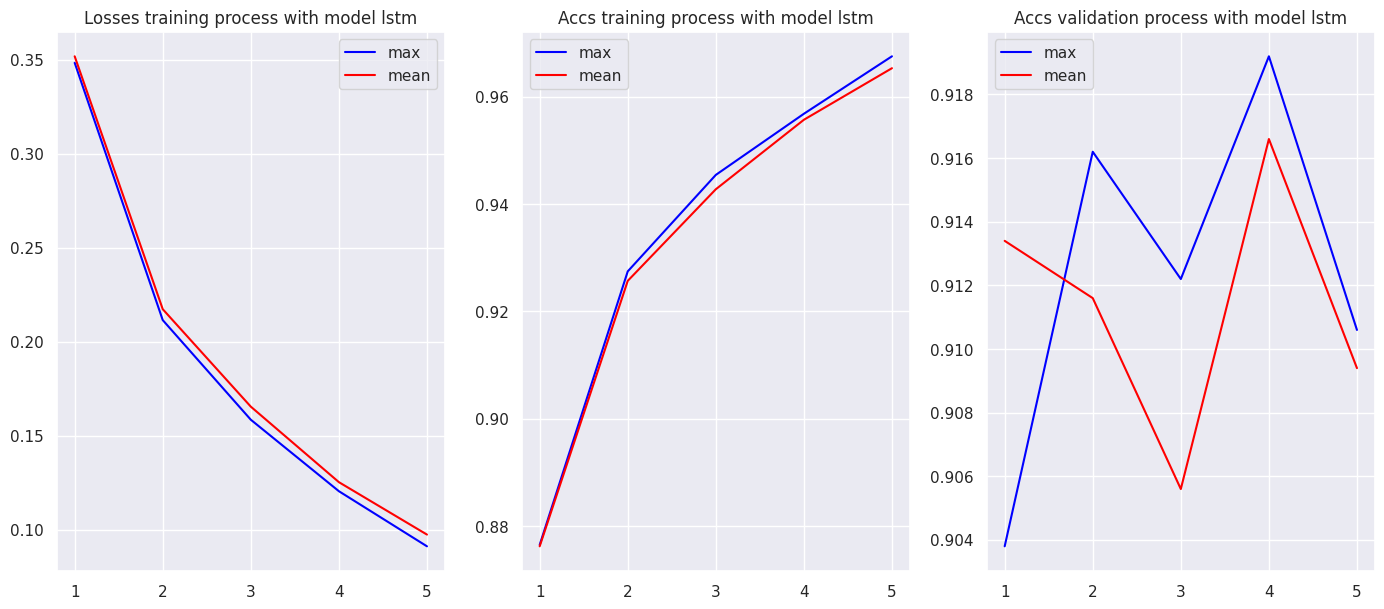

In [16]:
plot_results('lstm', losses_lstm_t, accs_lstm_t, accs_val_lstm_t, 5)

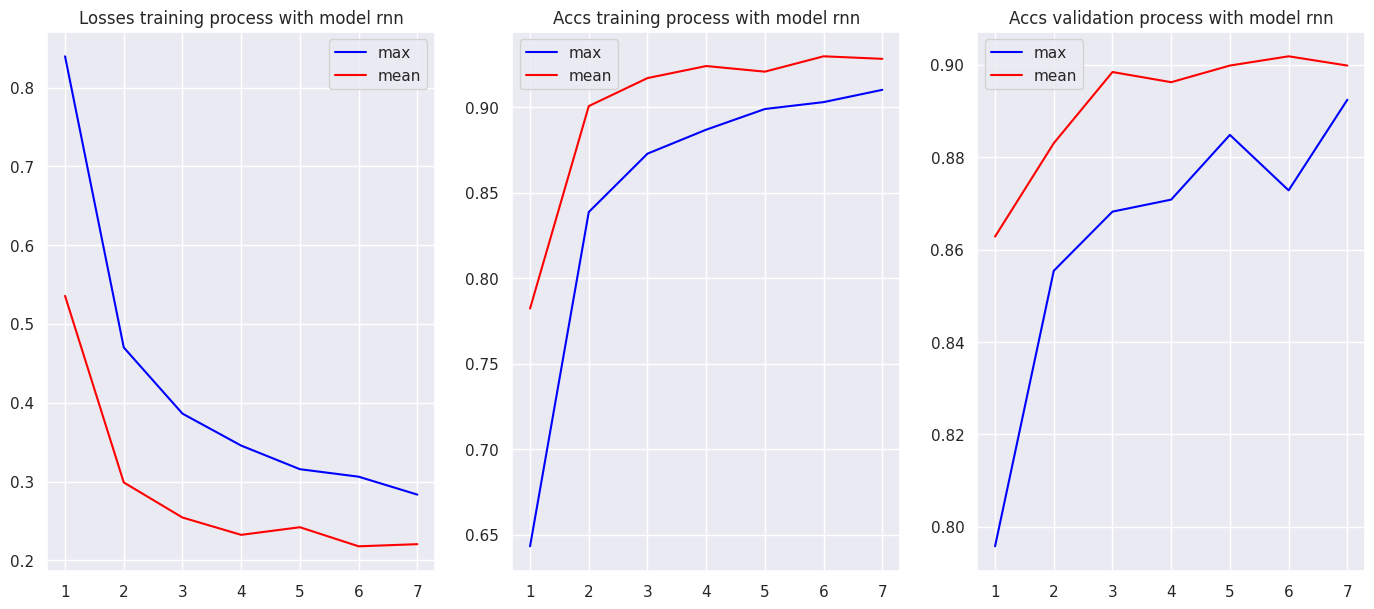

In [23]:
plot_results('rnn', losses_rnn_t, accs_rnn_t, accs_val_rnn_t, 7)

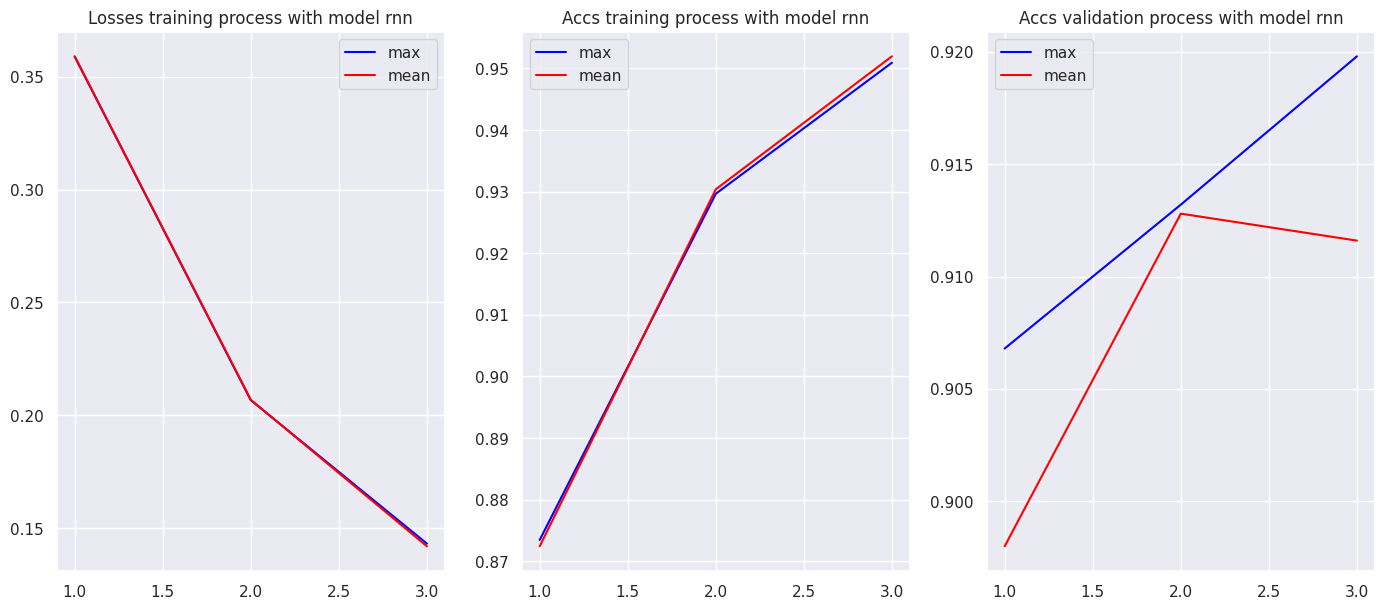

In [30]:
plot_results('rnn', losses_best_t, accs_best_t, accs_best_rnn_t, 3)

Вывод: 

    1) Таким образом было обучено 4 модели: 2 в ходе экспериментов, 1 в ходе получения лучшего качества и базовая rnn
    
    2) На графиках представлены в порядке сверху вниз следующие модели: базовая rnn, lstm с подбором параметров, улучшенная двунаправленная с несколькими слоями rnn и rnn с небольшим улучшением в виде подбора параметров и 2 слоями (лучшая модель). Также в случае улучшенных rnn для классификации текста использовались не только полученные эмббединги токенов, но и скрытые вектора h. 
    
    3) В целом можно сказать, что почти у всех моделей кроме базовой rnn нету четкого и стабильного графика точности на валидации, но в тоже время процесс обучения выглядит весьма стабильным
    
    4) При должном обучении и чуть более точном подборе параметров лучше всех себя смогла бы показать улучшенная rnn (2 и 4 модель), так как в процессе обучения на валидации ей удается достичь показателя accuracy около 0.92
    
    5) Лучше всего себя проявила чуть улучшенная rnn (4 модель)(лучшая модель), однако она была обучена на 3 эпохах, так как после она начинала переобучаться